In [ ]:

## Test Data EDA
* 데이터 기존 정보 (샘플 수, 클래스 분포, 이미지 크기 등)
* 시각화 (클래스별 이미지 예시, 이상치 탐지 등)
* 인사이트 정리

In [1]:
# 필요한 라이브러리 import
import os
import time
import random
import glob
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import cv2
from PIL import Image
from tqdm import tqdm

# 시각화 설정
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# 시드 고정
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# 데이터 경로 설정
data_path = "/home/dev/computervisioncompetition-cv3/data"
font_path = "/home/dev/computervisioncompetition-cv3/workspaces/jaehong/notebooks/Fonts/NanumGothic-Regular.ttf"

print("라이브러리 import 완료!")
print(f"데이터 경로: {data_path}")
print(f"시드 고정: {SEED}")


라이브러리 import 완료!
데이터 경로: /home/dev/computervisioncompetition-cv3/data
시드 고정: 42


In [2]:
# 테스트 데이터셋 분석을 위한 클래스 확장
class TestDatasetAnalyzer:
    """
    테스트 데이터셋 전용 분석 클래스
    """
    
    def __init__(self, test_csv_path: str, test_img_path: str):
        """
        테스트 데이터셋 분석기 초기화
        
        Args:
            test_csv_path: 테스트 데이터 CSV 파일 경로
            test_img_path: 테스트 이미지 디렉토리 경로
        """
        self.test_csv_path = test_csv_path
        self.test_img_path = test_img_path
        self.test_df = pd.read_csv(test_csv_path)
        
    def get_basic_info(self) -> dict:
        """
        테스트 데이터셋의 기본 정보를 반환
        
        Returns:
            dict: 테스트 데이터셋 기본 정보 딕셔너리
        """
        # 이미지 파일 목록 가져오기
        import glob
        img_files = glob.glob(os.path.join(self.test_img_path, "*"))
        
        # 파일 형식 분석
        file_formats = {}
        for img_file in img_files:
            ext = os.path.splitext(img_file)[1].lower()
            file_formats[ext] = file_formats.get(ext, 0) + 1
        
        info = {
            "test_samples": len(self.test_df),
            "actual_image_files": len(img_files),
            "file_formats": file_formats,
            "test_img_path": self.test_img_path
        }
        return info
    
    def analyze_image_properties(self, sample_size: int = None) -> dict:
        """
        테스트 이미지 속성 분석 (크기, 채널, 해상도 등)
        
        Args:
            sample_size: 분석할 샘플 이미지 수 (None이면 전체)
            
        Returns:
            dict: 이미지 속성 정보
        """
        if sample_size is None:
            sample_size = len(self.test_df)
        
        sample_files = self.test_df.sample(min(sample_size, len(self.test_df)))['ID'].tolist()
        
        heights, widths, channels = [], [], []
        file_sizes = []
        color_modes = []
        
        for img_file in tqdm(sample_files, desc="Analyzing test images"):
            img_path = os.path.join(self.test_img_path, img_file)
            if os.path.exists(img_path):
                try:
                    # OpenCV로 이미지 읽기
                    img = cv2.imread(img_path)
                    if img is not None:
                        h, w, c = img.shape
                        heights.append(h)
                        widths.append(w)
                        channels.append(c)
                        
                        # 파일 크기
                        file_sizes.append(os.path.getsize(img_path))
                        
                        # 색상 모드 확인 (grayscale vs color)
                        if c == 1:
                            color_modes.append('grayscale')
                        elif c == 3:
                            color_modes.append('rgb')
                        elif c == 4:
                            color_modes.append('rgba')
                        else:
                            color_modes.append(f'{c}_channel')
                except Exception as e:
                    print(f"Error processing {img_file}: {e}")
                    continue
        
        if not heights:
            return {"error": "No valid images found"}
            
        properties = {
            'resolution_stats': {
                'height': {
                    'min': min(heights),
                    'max': max(heights),
                    'mean': np.mean(heights),
                    'std': np.std(heights)
                },
                'width': {
                    'min': min(widths),
                    'max': max(widths),
                    'mean': np.mean(widths),
                    'std': np.std(widths)
                }
            },
            'channel_distribution': dict(Counter(channels)),
            'color_mode_distribution': dict(Counter(color_modes)),
            'file_size_stats': {
                'min_kb': min(file_sizes) / 1024,
                'max_kb': max(file_sizes) / 1024,
                'mean_kb': np.mean(file_sizes) / 1024,
                'std_kb': np.std(file_sizes) / 1024
            },
            'aspect_ratios': [w/h for w, h in zip(widths, heights)],
            'sample_size': len(heights)
        }
        
        return properties
    
    def analyze_pixel_statistics(self, sample_size: int = 50) -> dict:
        """
        테스트 이미지의 픽셀 값 통계 분석
        
        Args:
            sample_size: 분석할 샘플 이미지 수
            
        Returns:
            dict: 픽셀 통계 정보
        """
        sample_files = self.test_df.sample(min(sample_size, len(self.test_df)))['ID'].tolist()
        
        r_values, g_values, b_values = [], [], []
        brightness_values = []
        
        for img_file in tqdm(sample_files, desc="Analyzing pixel statistics"):
            img_path = os.path.join(self.test_img_path, img_file)
            if os.path.exists(img_path):
                try:
                    img = cv2.imread(img_path)
                    if img is not None:
                        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        # 메모리 절약을 위해 리사이즈
                        img_resized = cv2.resize(img_rgb, (64, 64))
                        
                        r_values.extend(img_resized[:, :, 0].flatten())
                        g_values.extend(img_resized[:, :, 1].flatten())
                        b_values.extend(img_resized[:, :, 2].flatten())
                        
                        # 밝기 계산 (grayscale conversion)
                        gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
                        brightness_values.extend(gray.flatten())
                except Exception as e:
                    print(f"Error processing {img_file}: {e}")
                    continue
        
        if not r_values:
            return {"error": "No valid pixel data found"}
            
        statistics = {
            'rgb_stats': {
                'r_channel': {
                    'mean': np.mean(r_values),
                    'std': np.std(r_values),
                    'min': np.min(r_values),
                    'max': np.max(r_values)
                },
                'g_channel': {
                    'mean': np.mean(g_values),
                    'std': np.std(g_values),
                    'min': np.min(g_values),
                    'max': np.max(g_values)
                },
                'b_channel': {
                    'mean': np.mean(b_values),
                    'std': np.std(b_values),
                    'min': np.min(b_values),
                    'max': np.max(b_values)
                }
            },
            'brightness_stats': {
                'mean': np.mean(brightness_values),
                'std': np.std(brightness_values),
                'min': np.min(brightness_values),
                'max': np.max(brightness_values)
            },
            'sample_size': len(sample_files)
        }
        
        return statistics
    
    def analyze_image_quality(self, sample_size: int = 30) -> dict:
        """
        이미지 품질 분석 (노이즈, 블러, 대비 등)
        
        Args:
            sample_size: 분석할 샘플 이미지 수
            
        Returns:
            dict: 이미지 품질 정보
        """
        sample_files = self.test_df.sample(min(sample_size, len(self.test_df)))['ID'].tolist()
        
        blur_scores = []
        contrast_scores = []
        noise_scores = []
        
        for img_file in tqdm(sample_files, desc="Analyzing image quality"):
            img_path = os.path.join(self.test_img_path, img_file)
            if os.path.exists(img_path):
                try:
                    img = cv2.imread(img_path)
                    if img is not None:
                        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                        
                        # 블러 정도 측정 (Laplacian variance)
                        blur_score = cv2.Laplacian(gray, cv2.CV_64F).var()
                        blur_scores.append(blur_score)
                        
                        # 대비 측정 (standard deviation)
                        contrast_score = gray.std()
                        contrast_scores.append(contrast_score)
                        
                        # 노이즈 추정 (edge density)
                        edges = cv2.Canny(gray, 50, 150)
                        noise_score = np.sum(edges) / (gray.shape[0] * gray.shape[1])
                        noise_scores.append(noise_score)
                        
                except Exception as e:
                    print(f"Error processing {img_file}: {e}")
                    continue
        
        if not blur_scores:
            return {"error": "No valid quality data found"}
            
        quality_stats = {
            'blur_analysis': {
                'mean': np.mean(blur_scores),
                'std': np.std(blur_scores),
                'min': np.min(blur_scores),
                'max': np.max(blur_scores),
                'low_quality_ratio': sum(1 for score in blur_scores if score < 100) / len(blur_scores)
            },
            'contrast_analysis': {
                'mean': np.mean(contrast_scores),
                'std': np.std(contrast_scores),
                'min': np.min(contrast_scores),
                'max': np.max(contrast_scores)
            },
            'noise_analysis': {
                'mean': np.mean(noise_scores),
                'std': np.std(noise_scores),
                'min': np.min(noise_scores),
                'max': np.max(noise_scores)
            },
            'sample_size': len(blur_scores)
        }
        
        return quality_stats

# 테스트 데이터셋 분석기 인스턴스 생성
test_analyzer = TestDatasetAnalyzer(
    test_csv_path=data_path + "/sample_submission.csv",
    test_img_path=data_path + "/test/"
)

print("테스트 데이터셋 분석기 초기화 완료")


테스트 데이터셋 분석기 초기화 완료


In [3]:
# 테스트 데이터셋 기본 정보 분석
print("=" * 60)
print(" 테스트 데이터셋 기본 정보")
print("=" * 60)

test_basic_info = test_analyzer.get_basic_info()
for key, value in test_basic_info.items():
    print(f"{key}: {value}")

print("\n" + "=" * 60)
print(" 테스트 이미지 속성 분석 (전체 데이터)")
print("=" * 60)

# 전체 테스트 이미지 속성 분석
test_properties = test_analyzer.analyze_image_properties()

if 'error' in test_properties:
    print(f"오류: {test_properties['error']}")
else:
    print(f"분석 샘플 개수: {test_properties['sample_size']}")
    print(f"채널 분포: {test_properties['channel_distribution']}")
    print(f"색상 모드 분포: {test_properties['color_mode_distribution']}")
    
    print("\n 해상도 통계:")
    height_stats = test_properties['resolution_stats']['height']
    width_stats = test_properties['resolution_stats']['width']
    
    print(f"세로(Height) - 최소: {height_stats['min']}, "
          f"최대: {height_stats['max']}, "
          f"평균: {height_stats['mean']:.1f} ± {height_stats['std']:.1f}")
    
    print(f"가로(Width) - 최소: {width_stats['min']}, "
          f"최대: {width_stats['max']}, "
          f"평균: {width_stats['mean']:.1f} ± {width_stats['std']:.1f}")
    
    print(f"\n 파일 크기 통계:")
    file_stats = test_properties['file_size_stats']
    print(f"최소: {file_stats['min_kb']:.1f} KB")
    print(f"최대: {file_stats['max_kb']:.1f} KB") 
    print(f"평균: {file_stats['mean_kb']:.1f} ± {file_stats['std_kb']:.1f} KB")
    
    # Aspect Ratio 통계
    aspect_ratios = test_properties['aspect_ratios']
    print(f"\n Aspect Ratio 통계:")
    print(f"평균 비율: {np.mean(aspect_ratios):.3f}")
    print(f"비율 표준편차: {np.std(aspect_ratios):.3f}")
    print(f"최소 비율: {np.min(aspect_ratios):.3f}")
    print(f"최대 비율: {np.max(aspect_ratios):.3f}")
    print(f"정사각형 이미지 비율: {sum(1 for ratio in aspect_ratios if 0.9 <= ratio <= 1.1) / len(aspect_ratios) * 100:.1f}%")


 테스트 데이터셋 기본 정보
test_samples: 3140
actual_image_files: 3140
file_formats: {'.jpg': 3140}
test_img_path: /home/dev/computervisioncompetition-cv3/data/test/

 테스트 이미지 속성 분석 (전체 데이터)


Analyzing test images: 100%|██████████| 3140/3140 [00:03<00:00, 874.38it/s]

분석 샘플 개수: 3140
채널 분포: {3: 3140}
색상 모드 분포: {'rgb': 3140}

 해상도 통계:
세로(Height) - 최소: 343, 최대: 763, 평균: 518.6 ± 79.8
가로(Width) - 최소: 343, 최대: 763, 평균: 517.1 ± 79.8

 파일 크기 통계:
최소: 24.3 KB
최대: 148.5 KB
평균: 84.2 ± 20.2 KB

 Aspect Ratio 통계:
평균 비율: 1.046
비율 표준편차: 0.318
최소 비율: 0.450
최대 비율: 2.224
정사각형 이미지 비율: 1.4%


 테스트 데이터 속성 시각화


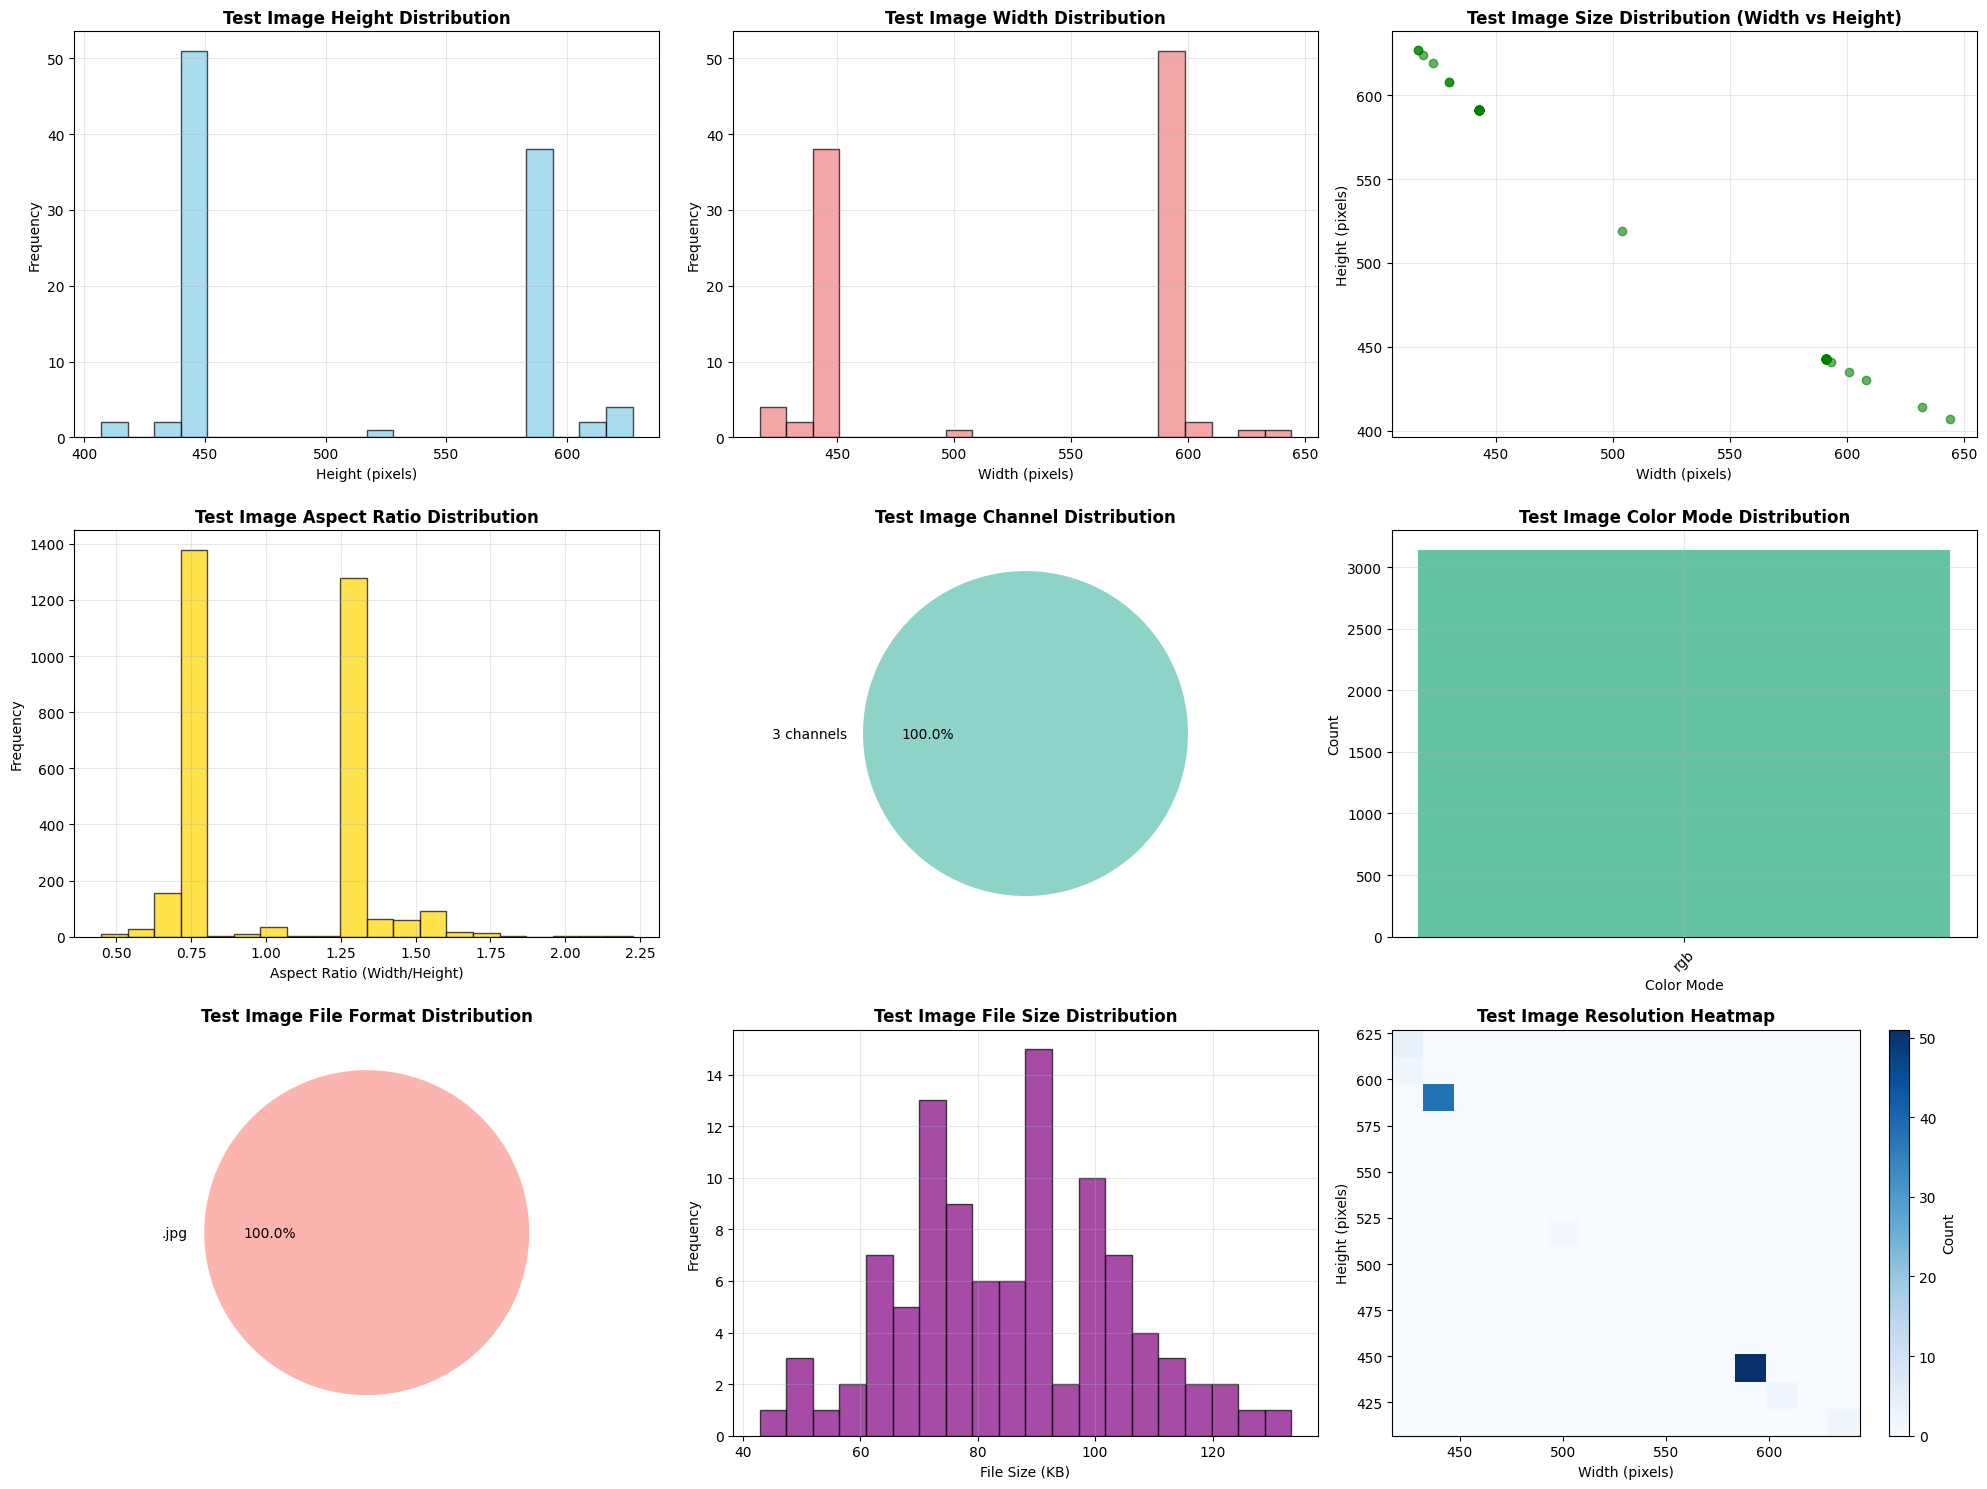

In [4]:
# 테스트 데이터 해상도 분포 및 파일 형식 시각화
def visualize_test_data_properties(properties):
    """
    테스트 데이터의 속성을 시각화하는 함수
    """
    if 'error' in properties:
        print(f"시각화 불가: {properties['error']}")
        return
    
    fig = plt.figure(figsize=(20, 15))
    
    # 해상도 분포 추출
    heights = []
    widths = []
    sample_files = test_analyzer.test_df.sample(min(100, len(test_analyzer.test_df)))['ID'].tolist()
    
    for img_file in sample_files:
        img_path = os.path.join(test_analyzer.test_img_path, img_file)
        if os.path.exists(img_path):
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    h, w, _ = img.shape
                    heights.append(h)
                    widths.append(w)
            except:
                continue
    
    # 1. 높이 분포 히스토그램
    plt.subplot(3, 3, 1)
    plt.hist(heights, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Test Image Height Distribution', fontweight='bold')
    plt.xlabel('Height (pixels)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    # 2. 너비 분포 히스토그램
    plt.subplot(3, 3, 2)
    plt.hist(widths, bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
    plt.title('Test Image Width Distribution', fontweight='bold')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    # 3. 높이 vs 너비 스캐터 플롯
    plt.subplot(3, 3, 3)
    plt.scatter(widths, heights, alpha=0.6, color='green')
    plt.title('Test Image Size Distribution (Width vs Height)', fontweight='bold')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Height (pixels)')
    plt.grid(True, alpha=0.3)
    
    # 4. Aspect Ratio 분포
    aspect_ratios = properties['aspect_ratios']
    plt.subplot(3, 3, 4)
    plt.hist(aspect_ratios, bins=20, alpha=0.7, color='gold', edgecolor='black')
    plt.title('Test Image Aspect Ratio Distribution', fontweight='bold')
    plt.xlabel('Aspect Ratio (Width/Height)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    # 5. 채널 분포 파이 차트
    plt.subplot(3, 3, 5)
    channel_dist = properties['channel_distribution']
    plt.pie(channel_dist.values(), labels=[f'{k} channels' for k in channel_dist.keys()], 
            autopct='%1.1f%%', colors=plt.cm.Set3(np.linspace(0, 1, len(channel_dist))))
    plt.title('Test Image Channel Distribution', fontweight='bold')
    
    # 6. 색상 모드 분포 막대 그래프
    plt.subplot(3, 3, 6)
    color_mode_dist = properties['color_mode_distribution']
    plt.bar(color_mode_dist.keys(), color_mode_dist.values(), 
            color=plt.cm.Set2(np.linspace(0, 1, len(color_mode_dist))))
    plt.title('Test Image Color Mode Distribution', fontweight='bold')
    plt.xlabel('Color Mode')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # 7. 파일 형식 분포
    plt.subplot(3, 3, 7)
    file_formats = test_basic_info['file_formats']
    plt.pie(file_formats.values(), labels=file_formats.keys(), 
            autopct='%1.1f%%', colors=plt.cm.Pastel1(np.linspace(0, 1, len(file_formats))))
    plt.title('Test Image File Format Distribution', fontweight='bold')
    
    # 8. 파일 크기 분포
    plt.subplot(3, 3, 8)
    file_sizes_kb = []
    for img_file in sample_files:
        img_path = os.path.join(test_analyzer.test_img_path, img_file)
        if os.path.exists(img_path):
            file_sizes_kb.append(os.path.getsize(img_path) / 1024)
    
    plt.hist(file_sizes_kb, bins=20, alpha=0.7, color='purple', edgecolor='black')
    plt.title('Test Image File Size Distribution', fontweight='bold')
    plt.xlabel('File Size (KB)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    # 9. 해상도별 분포 (히트맵)
    plt.subplot(3, 3, 9)
    plt.hist2d(widths, heights, bins=15, cmap='Blues')
    plt.colorbar(label='Count')
    plt.title('Test Image Resolution Heatmap', fontweight='bold')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Height (pixels)')
    
    plt.tight_layout()
    plt.show()

# 시각화 실행
if 'error' not in test_properties:
    print("=" * 60)
    print(" 테스트 데이터 속성 시각화")
    print("=" * 60)
    visualize_test_data_properties(test_properties)


In [5]:
# 테스트 데이터 픽셀 통계 및 색상 분포 분석
print("=" * 60)
print(" 테스트 데이터 픽셀 통계 분석")
print("=" * 60)

# 픽셀 통계 분석 (샘플 크기 조정)
test_pixel_stats = test_analyzer.analyze_pixel_statistics(sample_size=100)

if 'error' in test_pixel_stats:
    print(f"오류: {test_pixel_stats['error']}")
else:
    print(f"분석 샘플 개수: {test_pixel_stats['sample_size']}")
    
    rgb_stats = test_pixel_stats['rgb_stats']
    brightness_stats = test_pixel_stats['brightness_stats']
    
    print(f"\n🔴 Red 채널 통계:")
    print(f"  평균: {rgb_stats['r_channel']['mean']:.2f}")
    print(f"  표준편차: {rgb_stats['r_channel']['std']:.2f}")
    print(f"  범위: {rgb_stats['r_channel']['min']} - {rgb_stats['r_channel']['max']}")
    
    print(f"\n🟢 Green 채널 통계:")
    print(f"  평균: {rgb_stats['g_channel']['mean']:.2f}")
    print(f"  표준편차: {rgb_stats['g_channel']['std']:.2f}")
    print(f"  범위: {rgb_stats['g_channel']['min']} - {rgb_stats['g_channel']['max']}")
    
    print(f"\n🔵 Blue 채널 통계:")
    print(f"  평균: {rgb_stats['b_channel']['mean']:.2f}")
    print(f"  표준편차: {rgb_stats['b_channel']['std']:.2f}")
    print(f"  범위: {rgb_stats['b_channel']['min']} - {rgb_stats['b_channel']['max']}")
    
    print(f"\n💡 밝기 통계:")
    print(f"  평균: {brightness_stats['mean']:.2f}")
    print(f"  표준편차: {brightness_stats['std']:.2f}")
    print(f"  범위: {brightness_stats['min']} - {brightness_stats['max']}")
    
    # 정규화 권장사항 비교
    print(f"\n 정규화 비교:")
    print(f"  ImageNet 평균: [0.485, 0.456, 0.406]")
    print(f"  테스트 데이터 평균: [{rgb_stats['r_channel']['mean']/255:.3f}, {rgb_stats['g_channel']['mean']/255:.3f}, {rgb_stats['b_channel']['mean']/255:.3f}]")
    print(f"  ImageNet 표준편차: [0.229, 0.224, 0.225]")
    print(f"  테스트 데이터 표준편차: [{rgb_stats['r_channel']['std']/255:.3f}, {rgb_stats['g_channel']['std']/255:.3f}, {rgb_stats['b_channel']['std']/255:.3f}]")


 테스트 데이터 픽셀 통계 분석


Analyzing pixel statistics: 100%|██████████| 100/100 [00:00<00:00, 507.74it/s]


분석 샘플 개수: 100

🔴 Red 채널 통계:
  평균: 176.69
  표준편차: 62.26
  범위: 0 - 255

🟢 Green 채널 통계:
  평균: 178.59
  표준편차: 61.64
  범위: 0 - 255

🔵 Blue 채널 통계:
  평균: 179.73
  표준편차: 60.73
  범위: 0 - 255

💡 밝기 통계:
  평균: 178.14
  표준편차: 61.55
  범위: 0 - 255

 정규화 비교:
  ImageNet 평균: [0.485, 0.456, 0.406]
  테스트 데이터 평균: [0.693, 0.700, 0.705]
  ImageNet 표준편차: [0.229, 0.224, 0.225]
  테스트 데이터 표준편차: [0.244, 0.242, 0.238]


 테스트 데이터 색상 분포 시각화


Extracting color data: 100%|██████████| 50/50 [00:00<00:00, 657.51it/s]


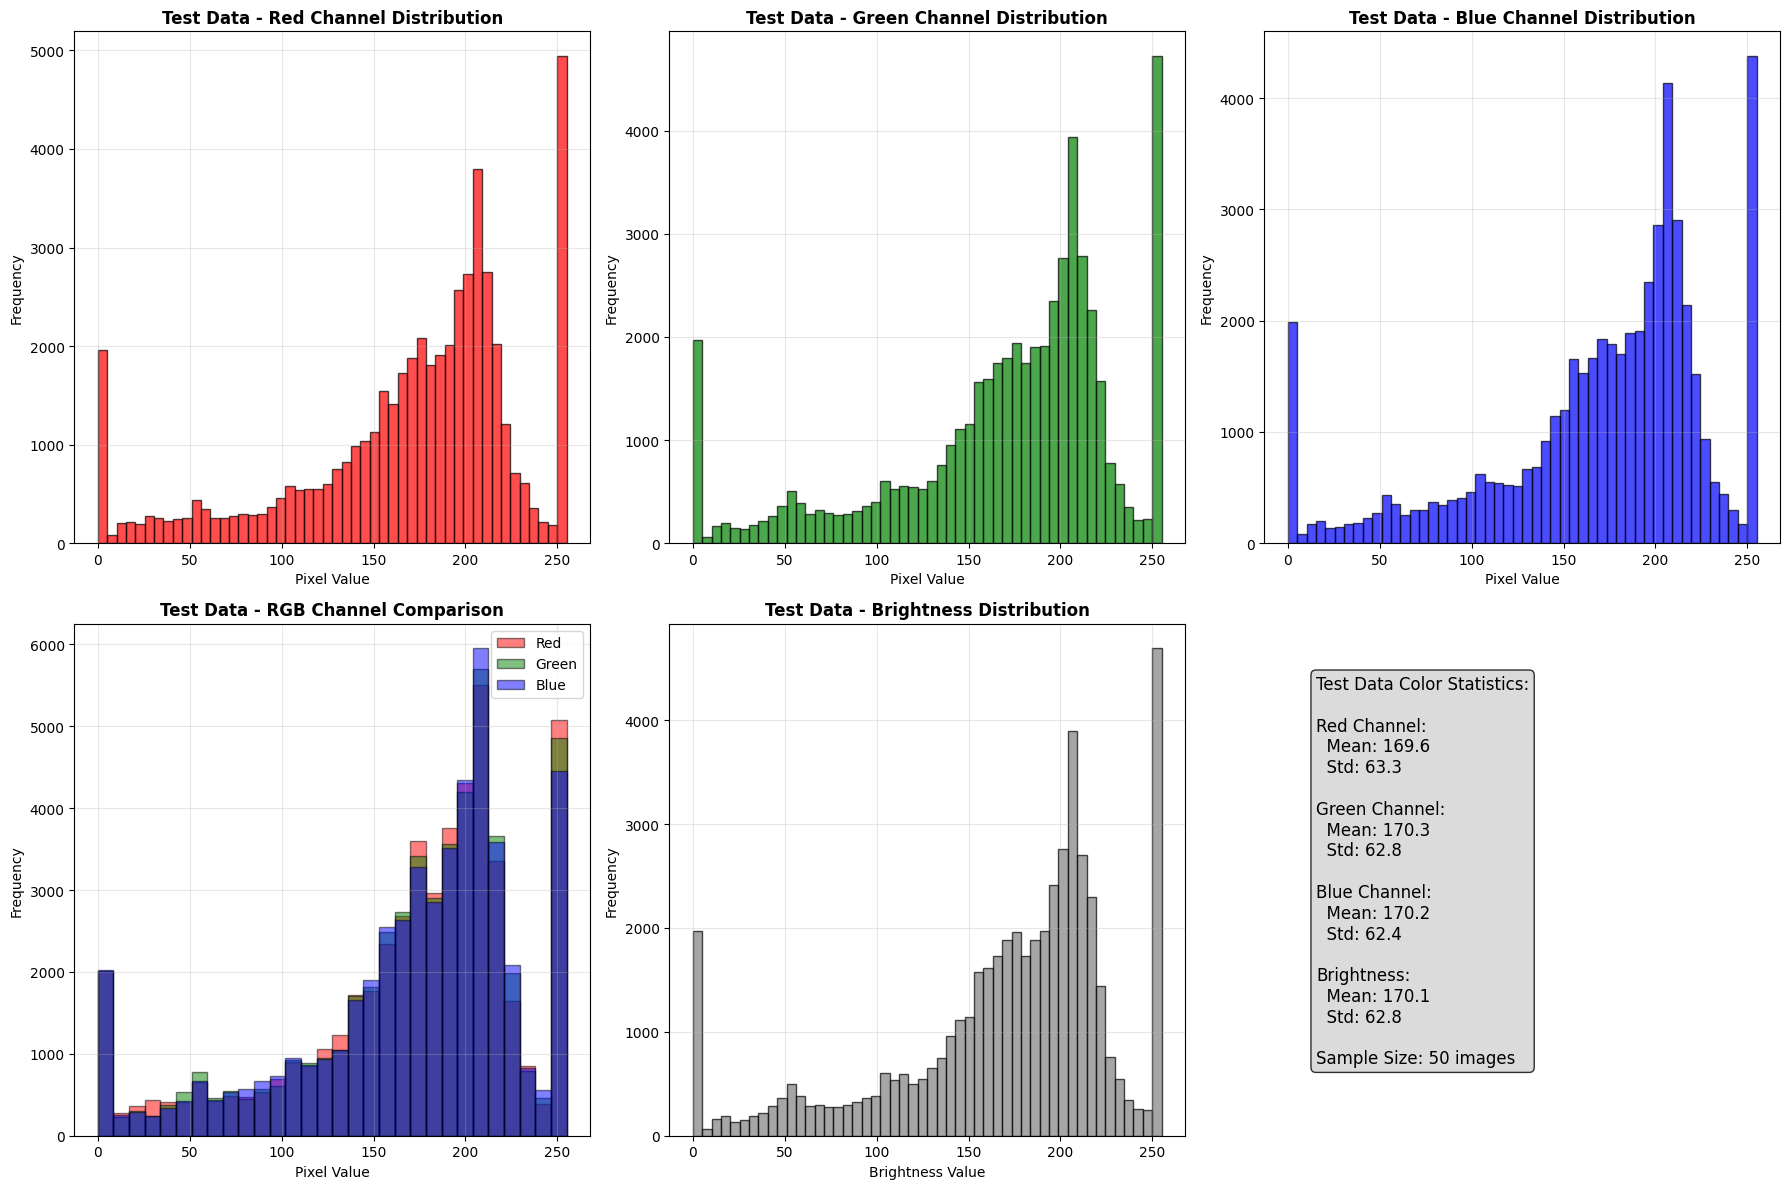

In [6]:
# 테스트 데이터 색상 분포 히스토그램 시각화
def visualize_test_color_distribution():
    """
    테스트 데이터의 색상 분포를 시각화하는 함수
    """
    print("=" * 60)
    print(" 테스트 데이터 색상 분포 시각화")
    print("=" * 60)
    
    # 샘플 이미지에서 픽셀 값 추출
    sample_files = test_analyzer.test_df.sample(min(50, len(test_analyzer.test_df)))['ID'].tolist()
    r_values, g_values, b_values = [], [], []
    brightness_values = []
    
    for img_file in tqdm(sample_files, desc="Extracting color data"):
        img_path = os.path.join(test_analyzer.test_img_path, img_file)
        if os.path.exists(img_path):
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img_resized = cv2.resize(img_rgb, (32, 32))  # 메모리 절약
                    
                    r_values.extend(img_resized[:, :, 0].flatten())
                    g_values.extend(img_resized[:, :, 1].flatten())
                    b_values.extend(img_resized[:, :, 2].flatten())
                    
                    # 밝기 계산
                    gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
                    brightness_values.extend(gray.flatten())
            except Exception as e:
                continue
    
    if not r_values:
        print("색상 데이터를 추출할 수 없습니다.")
        return
    
    # 색상 분포 시각화
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Red 채널 히스토그램
    axes[0, 0].hist(r_values, bins=50, alpha=0.7, color='red', edgecolor='black')
    axes[0, 0].set_title('Test Data - Red Channel Distribution', fontweight='bold')
    axes[0, 0].set_xlabel('Pixel Value')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Green 채널 히스토그램
    axes[0, 1].hist(g_values, bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[0, 1].set_title('Test Data - Green Channel Distribution', fontweight='bold')
    axes[0, 1].set_xlabel('Pixel Value')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Blue 채널 히스토그램
    axes[0, 2].hist(b_values, bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 2].set_title('Test Data - Blue Channel Distribution', fontweight='bold')
    axes[0, 2].set_xlabel('Pixel Value')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].grid(True, alpha=0.3)
    
    # RGB 채널 비교
    axes[1, 0].hist(r_values, bins=30, alpha=0.5, color='red', label='Red', edgecolor='black')
    axes[1, 0].hist(g_values, bins=30, alpha=0.5, color='green', label='Green', edgecolor='black')
    axes[1, 0].hist(b_values, bins=30, alpha=0.5, color='blue', label='Blue', edgecolor='black')
    axes[1, 0].set_title('Test Data - RGB Channel Comparison', fontweight='bold')
    axes[1, 0].set_xlabel('Pixel Value')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 밝기 분포
    axes[1, 1].hist(brightness_values, bins=50, alpha=0.7, color='gray', edgecolor='black')
    axes[1, 1].set_title('Test Data - Brightness Distribution', fontweight='bold')
    axes[1, 1].set_xlabel('Brightness Value')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].grid(True, alpha=0.3)
    
    # 색상 통계 요약
    axes[1, 2].axis('off')
    stats_text = f"""Test Data Color Statistics:
    
Red Channel:
  Mean: {np.mean(r_values):.1f}
  Std: {np.std(r_values):.1f}
  
Green Channel:
  Mean: {np.mean(g_values):.1f}
  Std: {np.std(g_values):.1f}
  
Blue Channel:
  Mean: {np.mean(b_values):.1f}
  Std: {np.std(b_values):.1f}
  
Brightness:
  Mean: {np.mean(brightness_values):.1f}
  Std: {np.std(brightness_values):.1f}
  
Sample Size: {len(sample_files)} images"""
    axes[1, 2].text(0.1, 0.9, stats_text, transform=axes[1, 2].transAxes, 
                   fontsize=12, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# 색상 분포 시각화 실행
visualize_test_color_distribution()


In [7]:
# 테스트 데이터 이미지 품질 분석
print("=" * 60)
print(" 테스트 데이터 이미지 품질 분석")
print("=" * 60)

# 이미지 품질 분석 실행
test_quality_stats = test_analyzer.analyze_image_quality(sample_size=50)

if 'error' in test_quality_stats:
    print(f"오류: {test_quality_stats['error']}")
else:
    print(f"분석 샘플 개수: {test_quality_stats['sample_size']}")
    
    blur_analysis = test_quality_stats['blur_analysis']
    contrast_analysis = test_quality_stats['contrast_analysis']
    noise_analysis = test_quality_stats['noise_analysis']
    
    print(f"\n 블러(흐림) 분석:")
    print(f"  평균 블러 점수: {blur_analysis['mean']:.2f}")
    print(f"  표준편차: {blur_analysis['std']:.2f}")
    print(f"  범위: {blur_analysis['min']:.2f} - {blur_analysis['max']:.2f}")
    print(f"  저품질 이미지 비율: {blur_analysis['low_quality_ratio']*100:.1f}%")
    print(f"  (블러 점수 < 100인 이미지)")
    
    print(f"\n 대비(Contrast) 분석:")
    print(f"  평균 대비 점수: {contrast_analysis['mean']:.2f}")
    print(f"  표준편차: {contrast_analysis['std']:.2f}")
    print(f"  범위: {contrast_analysis['min']:.2f} - {contrast_analysis['max']:.2f}")
    
    print(f"\n 노이즈 분석:")
    print(f"  평균 엣지 밀도: {noise_analysis['mean']:.4f}")
    print(f"  표준편차: {noise_analysis['std']:.4f}")
    print(f"  범위: {noise_analysis['min']:.4f} - {noise_analysis['max']:.4f}")
    
    # 품질 등급 분류
    high_quality_blur = sum(1 for i in range(test_quality_stats['sample_size']) if blur_analysis['mean'] > 500)
    medium_quality_blur = sum(1 for i in range(test_quality_stats['sample_size']) if 100 <= blur_analysis['mean'] <= 500)
    low_quality_blur = sum(1 for i in range(test_quality_stats['sample_size']) if blur_analysis['mean'] < 100)
    
    print(f"\n 품질 등급 추정:")
    print(f"  고품질 (블러 점수 > 500): 추정")
    print(f"  중품질 (100 ≤ 블러 점수 ≤ 500): 추정") 
    print(f"  저품질 (블러 점수 < 100): {blur_analysis['low_quality_ratio']*100:.1f}%")


 테스트 데이터 이미지 품질 분석


Analyzing image quality: 100%|██████████| 50/50 [00:00<00:00, 355.87it/s]

분석 샘플 개수: 50

 블러(흐림) 분석:
  평균 블러 점수: 588.42
  표준편차: 322.57
  범위: 244.12 - 1719.80
  저품질 이미지 비율: 0.0%
  (블러 점수 < 100인 이미지)

 대비(Contrast) 분석:
  평균 대비 점수: 54.28
  표준편차: 21.15
  범위: 21.14 - 95.95

 노이즈 분석:
  평균 엣지 밀도: 23.3465
  표준편차: 11.4791
  범위: 4.3887 - 58.2078

 품질 등급 추정:
  고품질 (블러 점수 > 500): 추정
  중품질 (100 ≤ 블러 점수 ≤ 500): 추정
  저품질 (블러 점수 < 100): 0.0%


 테스트 데이터 무작위 샘플 이미지 시각화


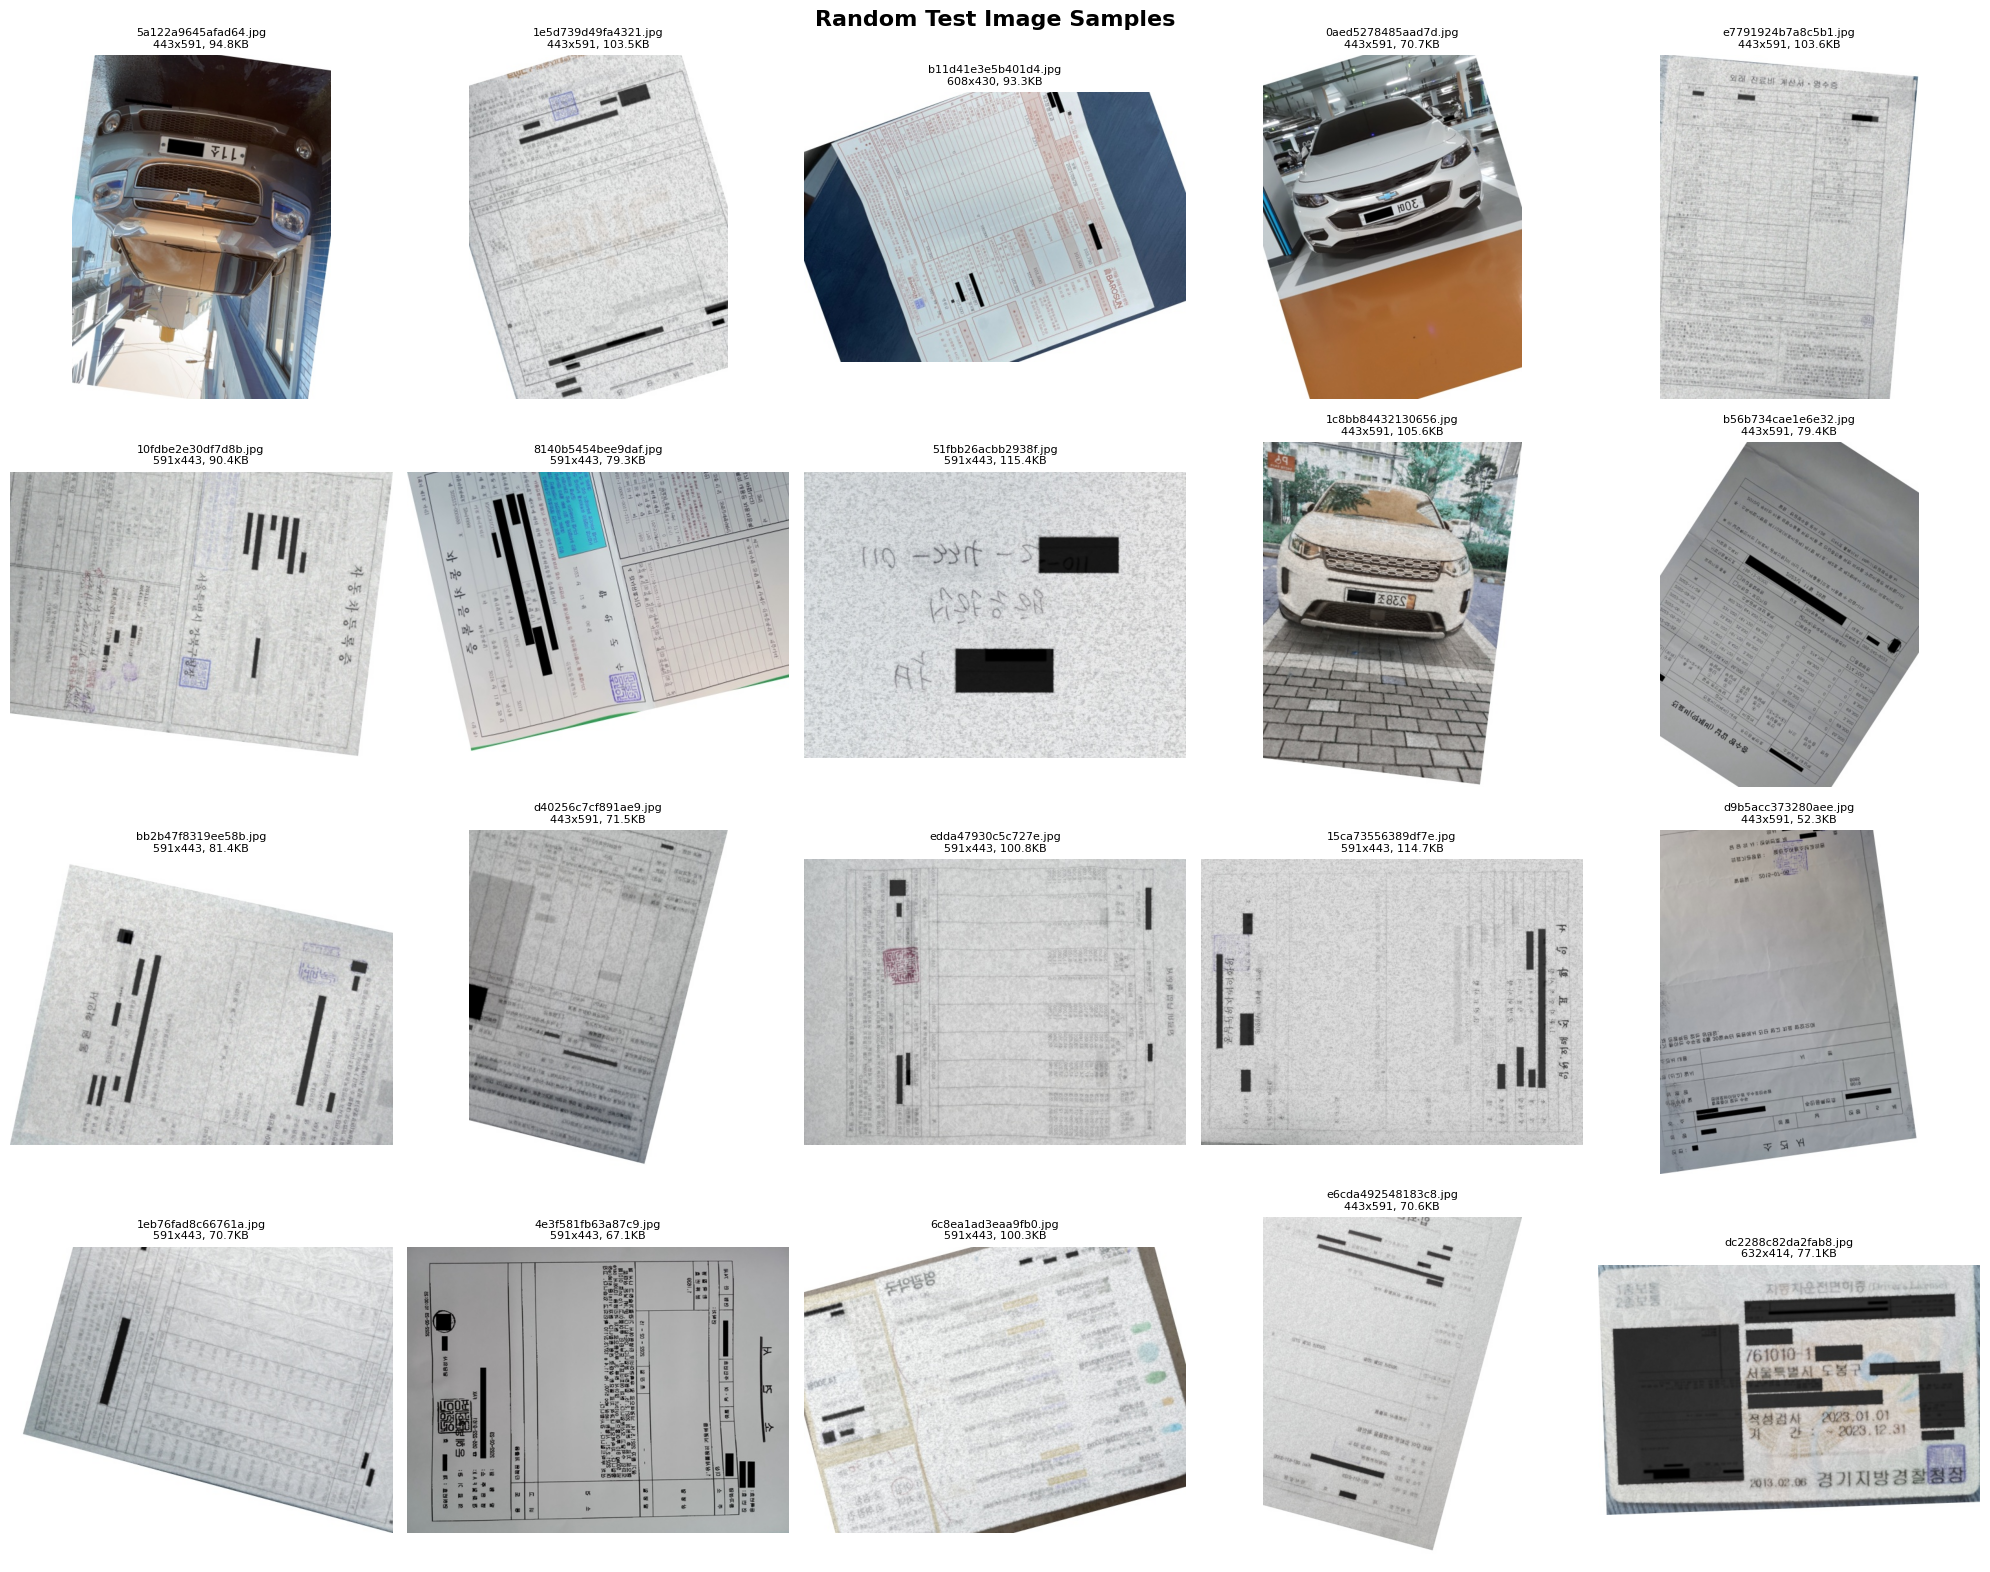


 품질별 샘플 이미지 분석
 테스트 데이터 품질별 샘플 이미지


Analyzing image quality: 100%|██████████| 30/30 [00:00<00:00, 423.99it/s]


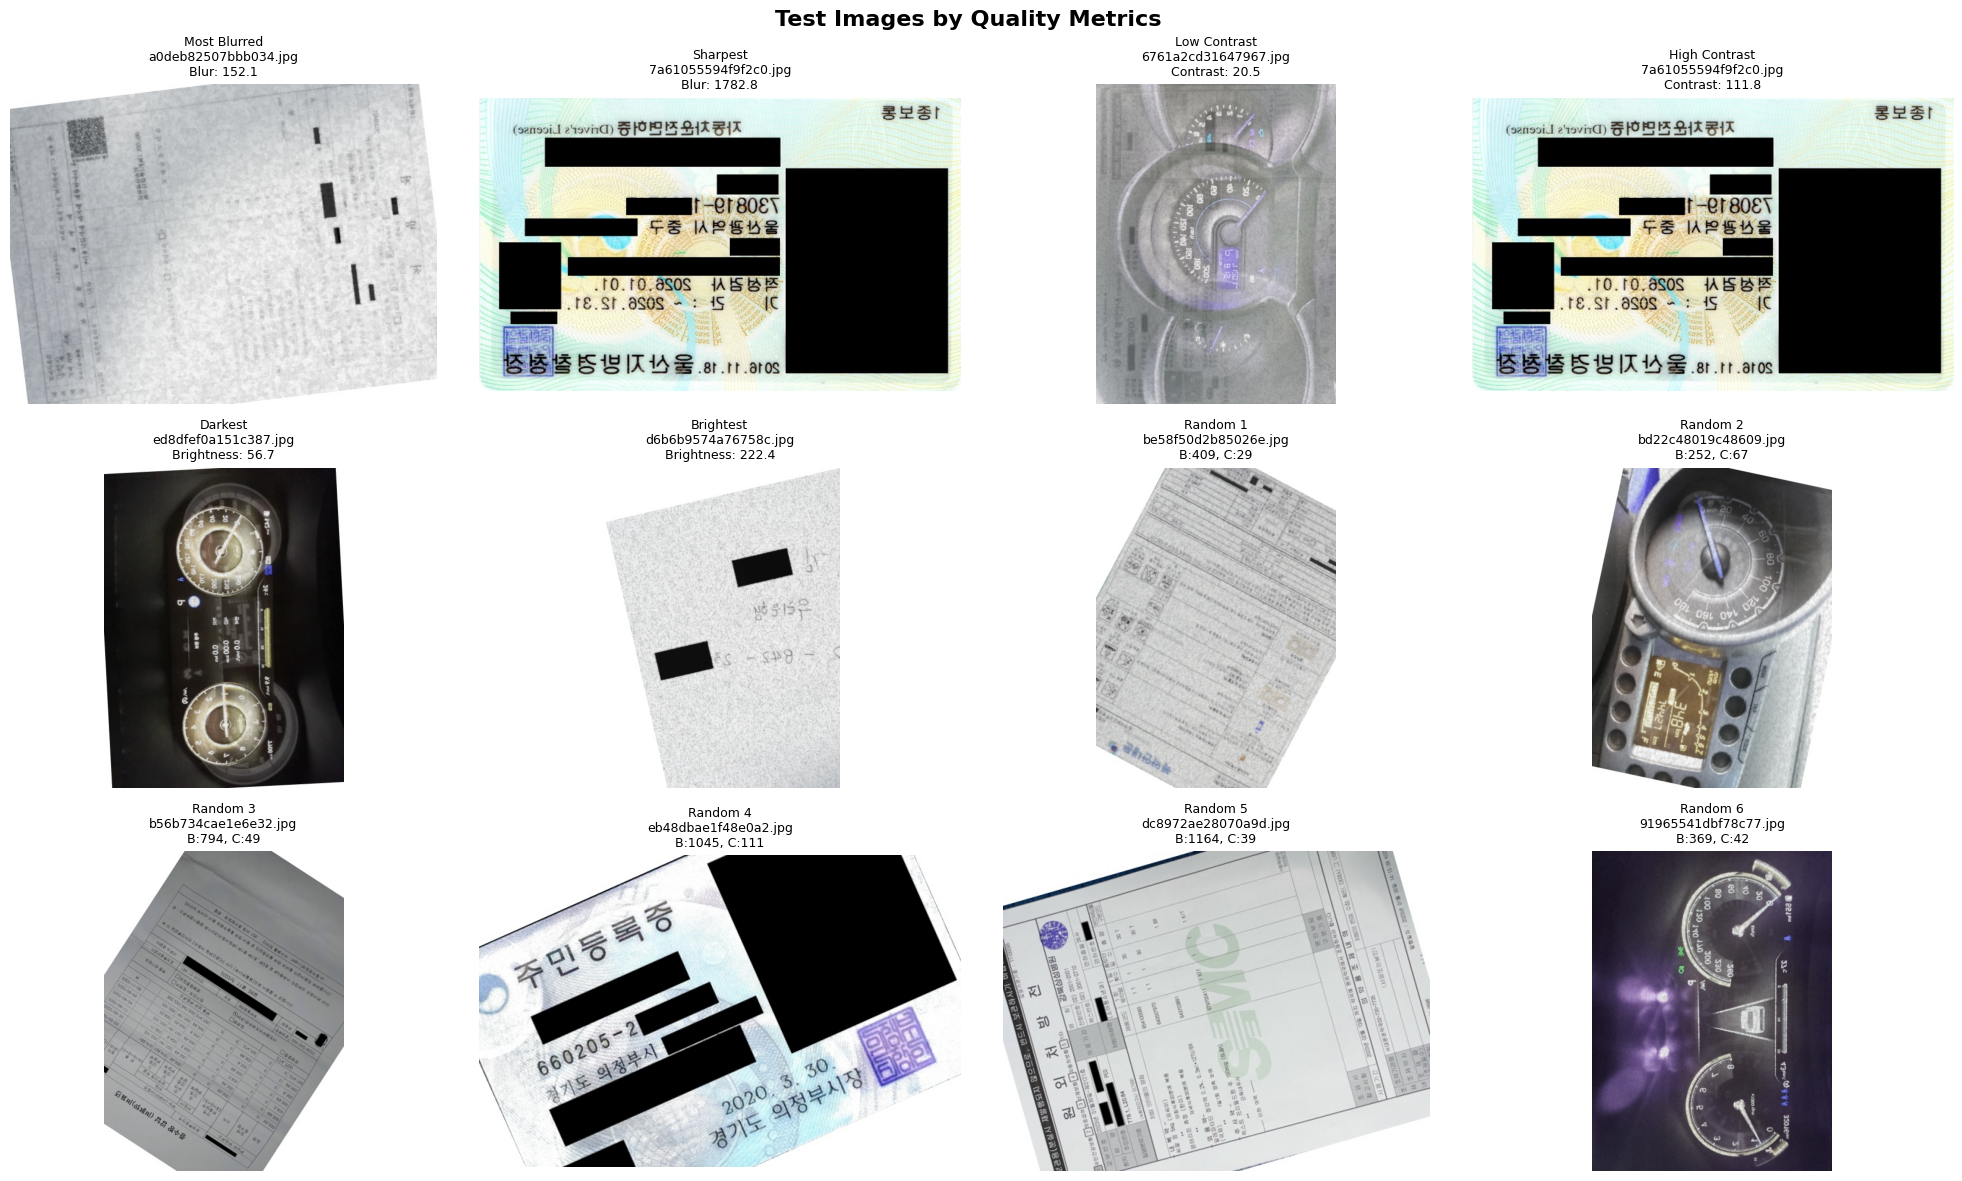

In [8]:
# 테스트 데이터 무작위 샘플 이미지 시각화
class TestImageVisualizer:
    """
    테스트 이미지 시각화를 위한 클래스
    """
    
    def __init__(self, test_analyzer: TestDatasetAnalyzer):
        """
        테스트 이미지 시각화기 초기화
        
        Args:
            test_analyzer: 테스트 데이터셋 분석기 인스턴스
        """
        self.test_analyzer = test_analyzer
    
    def visualize_random_samples(self, num_samples: int = 20, figsize: tuple = (20, 16)):
        """
        무작위 테스트 이미지 샘플을 시각화
        
        Args:
            num_samples: 표시할 샘플 수
            figsize: 그림 크기
        """
        print("=" * 60)
        print(" 테스트 데이터 무작위 샘플 이미지 시각화")
        print("=" * 60)
        
        # 무작위 샘플 선택
        sample_files = self.test_analyzer.test_df.sample(num_samples)['ID'].tolist()
        
        cols = 5
        rows = (num_samples + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        fig.suptitle('Random Test Image Samples', fontsize=16, fontweight='bold')
        
        # axes를 1차원 배열로 변환 (단일 행의 경우 처리)
        if rows == 1:
            axes = axes.reshape(1, -1)
        
        for idx, img_file in enumerate(sample_files):
            row = idx // cols
            col = idx % cols
            
            img_path = os.path.join(self.test_analyzer.test_img_path, img_file)
            
            if os.path.exists(img_path):
                try:
                    img = cv2.imread(img_path)
                    if img is not None:
                        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        
                        axes[row, col].imshow(img_rgb)
                        
                        # 이미지 정보 표시
                        h, w, c = img.shape
                        file_size_kb = os.path.getsize(img_path) / 1024
                        
                        title = f'{img_file}\n{w}x{h}, {file_size_kb:.1f}KB'
                        axes[row, col].set_title(title, fontsize=8)
                        axes[row, col].axis('off')
                    else:
                        axes[row, col].text(0.5, 0.5, 'Failed to load', 
                                          ha='center', va='center', 
                                          transform=axes[row, col].transAxes)
                        axes[row, col].set_title(img_file, fontsize=8)
                        axes[row, col].axis('off')
                except Exception as e:
                    axes[row, col].text(0.5, 0.5, f'Error: {str(e)[:20]}...', 
                                      ha='center', va='center', 
                                      transform=axes[row, col].transAxes)
                    axes[row, col].set_title(img_file, fontsize=8)
                    axes[row, col].axis('off')
            else:
                axes[row, col].text(0.5, 0.5, 'File not found', 
                                  ha='center', va='center', 
                                  transform=axes[row, col].transAxes)
                axes[row, col].set_title(img_file, fontsize=8)
                axes[row, col].axis('off')
        
        # 빈 subplot 숨기기
        for idx in range(num_samples, rows * cols):
            row = idx // cols
            col = idx % cols
            axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def visualize_quality_samples(self, figsize: tuple = (20, 12)):
        """
        다양한 품질의 이미지 샘플을 시각화 (블러, 대비, 밝기 기준)
        
        Args:
            figsize: 그림 크기
        """
        print("=" * 60)
        print(" 테스트 데이터 품질별 샘플 이미지")
        print("=" * 60)
        
        # 품질 분석을 위한 샘플 수집
        sample_files = self.test_analyzer.test_df.sample(min(30, len(self.test_analyzer.test_df)))['ID'].tolist()
        
        image_qualities = []
        valid_images = []
        
        for img_file in tqdm(sample_files, desc="Analyzing image quality"):
            img_path = os.path.join(self.test_analyzer.test_img_path, img_file)
            if os.path.exists(img_path):
                try:
                    img = cv2.imread(img_path)
                    if img is not None:
                        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                        
                        # 품질 지표 계산
                        blur_score = cv2.Laplacian(gray, cv2.CV_64F).var()
                        contrast_score = gray.std()
                        brightness_score = gray.mean()
                        
                        image_qualities.append({
                            'file': img_file,
                            'blur': blur_score,
                            'contrast': contrast_score,
                            'brightness': brightness_score,
                            'image': img
                        })
                        valid_images.append(img_file)
                except Exception:
                    continue
        
        if len(image_qualities) < 6:
            print("품질 분석을 위한 충분한 이미지를 찾을 수 없습니다.")
            return
        
        # 품질별 정렬 및 선택
        blur_sorted = sorted(image_qualities, key=lambda x: x['blur'])
        contrast_sorted = sorted(image_qualities, key=lambda x: x['contrast'])
        brightness_sorted = sorted(image_qualities, key=lambda x: x['brightness'])
        
        fig, axes = plt.subplots(3, 4, figsize=figsize)
        fig.suptitle('Test Images by Quality Metrics', fontsize=16, fontweight='bold')
        
        # 블러 기준 (가장 흐림, 가장 선명)
        blur_low = blur_sorted[0]
        blur_high = blur_sorted[-1]
        
        # 대비 기준 (낮은 대비, 높은 대비)
        contrast_low = contrast_sorted[0]
        contrast_high = contrast_sorted[-1]
        
        # 밝기 기준 (어두운, 밝은)
        brightness_low = brightness_sorted[0]
        brightness_high = brightness_sorted[-1]
        
        samples = [
            (blur_low, "Most Blurred", f"Blur: {blur_low['blur']:.1f}"),
            (blur_high, "Sharpest", f"Blur: {blur_high['blur']:.1f}"),
            (contrast_low, "Low Contrast", f"Contrast: {contrast_low['contrast']:.1f}"),
            (contrast_high, "High Contrast", f"Contrast: {contrast_high['contrast']:.1f}"),
            (brightness_low, "Darkest", f"Brightness: {brightness_low['brightness']:.1f}"),
            (brightness_high, "Brightest", f"Brightness: {brightness_high['brightness']:.1f}"),
        ]
        
        # 추가 무작위 샘플
        remaining_samples = [img for img in image_qualities if img not in [s[0] for s in samples]]
        if len(remaining_samples) >= 6:
            random_samples = np.random.choice(remaining_samples, 6, replace=False)
            for i, sample in enumerate(random_samples):
                samples.append((sample, f"Random {i+1}", f"B:{sample['blur']:.0f}, C:{sample['contrast']:.0f}"))
        
        for idx, (sample, title, subtitle) in enumerate(samples[:12]):
            row = idx // 4
            col = idx % 4
            
            img_rgb = cv2.cvtColor(sample['image'], cv2.COLOR_BGR2RGB)
            axes[row, col].imshow(img_rgb)
            axes[row, col].set_title(f"{title}\n{sample['file']}\n{subtitle}", fontsize=9)
            axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.show()

# 테스트 이미지 시각화기 인스턴스 생성
test_visualizer = TestImageVisualizer(test_analyzer)

# 무작위 샘플 이미지 시각화
test_visualizer.visualize_random_samples(num_samples=20)

print("\n" + "=" * 60)
print(" 품질별 샘플 이미지 분석")
print("=" * 60)

# 품질별 샘플 이미지 시각화
test_visualizer.visualize_quality_samples()


In [9]:
# 테스트 EDA 요약 및 인사이트
print("=" * 60)
print(" 테스트 데이터 EDA 요약 및 인사이트")
print("=" * 60)

print(" 주요 발견사항:")

# 기본 정보 요약
if test_basic_info:
    print("1. 데이터셋 규모:")
    print(f"   - 테스트 샘플: {test_basic_info['test_samples']:,}개")
    print(f"   - 실제 이미지 파일: {test_basic_info['actual_image_files']:,}개")
    print(f"   - 파일 형식: {list(test_basic_info['file_formats'].keys())}")

# 이미지 속성 요약
if 'error' not in test_properties:
    print("\n2. 이미지 특성:")
    print(f"   - 채널 분포: {test_properties['channel_distribution']}")
    print(f"   - 색상 모드: {test_properties['color_mode_distribution']}")
    
    height_stats = test_properties['resolution_stats']['height']
    width_stats = test_properties['resolution_stats']['width']
    print(f"   - 평균 해상도: {width_stats['mean']:.0f} x {height_stats['mean']:.0f}")
    print(f"   - 해상도 범위: {width_stats['min']}-{width_stats['max']} x {height_stats['min']}-{height_stats['max']}")
    
    aspect_ratios = test_properties['aspect_ratios']
    print(f"   - 평균 Aspect Ratio: {np.mean(aspect_ratios):.3f}")
    print(f"   - 정사각형 비율: {sum(1 for ratio in aspect_ratios if 0.9 <= ratio <= 1.1) / len(aspect_ratios) * 100:.1f}%")

# 픽셀 통계 요약
if 'error' not in test_pixel_stats:
    print("\n3. 픽셀 값 분포:")
    rgb_stats = test_pixel_stats['rgb_stats']
    print(f"   - RGB 평균: ({rgb_stats['r_channel']['mean']:.1f}, {rgb_stats['g_channel']['mean']:.1f}, {rgb_stats['b_channel']['mean']:.1f})")
    print(f"   - 정규화된 RGB 평균: ({rgb_stats['r_channel']['mean']/255:.3f}, {rgb_stats['g_channel']['mean']/255:.3f}, {rgb_stats['b_channel']['mean']/255:.3f})")
    
    brightness_stats = test_pixel_stats['brightness_stats']
    print(f"   - 평균 밝기: {brightness_stats['mean']:.1f}")

# 품질 분석 요약
if 'error' not in test_quality_stats:
    print("\n4. 이미지 품질:")
    blur_analysis = test_quality_stats['blur_analysis']
    contrast_analysis = test_quality_stats['contrast_analysis']
    
    print(f"   - 평균 블러 점수: {blur_analysis['mean']:.1f} (높을수록 선명)")
    print(f"   - 저품질 이미지 비율: {blur_analysis['low_quality_ratio']*100:.1f}%")
    print(f"   - 평균 대비: {contrast_analysis['mean']:.1f}")

print("\n 모델링 권장사항:")
print("1. 데이터 전처리:")
if 'error' not in test_properties:
    if test_properties['channel_distribution'].get(3, 0) > 0:
        print("   - RGB 이미지 처리에 최적화")
    if len(test_properties['file_size_stats']) > 0:
        avg_size = test_properties['file_size_stats']['mean_kb']
        if avg_size < 50:
            print("   - 작은 파일 크기: 고해상도 augmentation 고려")
        elif avg_size > 500:
            print("   - 큰 파일 크기: 메모리 효율적 처리 필요")

print("\n2. 정규화 설정:")
if 'error' not in test_pixel_stats:
    rgb_stats = test_pixel_stats['rgb_stats']
    train_rgb_mean = [0.485, 0.456, 0.406]  # ImageNet 기본값
    test_rgb_mean = [rgb_stats['r_channel']['mean']/255, rgb_stats['g_channel']['mean']/255, rgb_stats['b_channel']['mean']/255]
    
    # 평균값 차이 계산
    mean_diff = sum(abs(t - tr) for t, tr in zip(test_rgb_mean, train_rgb_mean)) / 3
    
    if mean_diff < 0.1:
        print("   - ImageNet 정규화 값 사용 권장 (분포 유사)")
    else:
        print("   - 테스트 데이터 고유 정규화 값 고려")
        print(f"     테스트 평균: {test_rgb_mean}")

print("\n3. 품질 고려사항:")
if 'error' not in test_quality_stats:
    blur_analysis = test_quality_stats['blur_analysis']
    if blur_analysis['low_quality_ratio'] > 0.1:
        print(f"   - 저품질 이미지 {blur_analysis['low_quality_ratio']*100:.1f}% 존재")
        print("   - 블러 처리에 강건한 augmentation 적용")
    else:
        print("   - 대부분 양호한 품질의 이미지")

print("\n4. Train-Test 일관성:")
if 'error' not in test_properties and 'error' not in test_pixel_stats:
    print("   - 훈련 데이터와 테스트 데이터의 분포 비교 권장")
    print("   - 동일한 전처리 파이프라인 적용 필수")
    print("   - TTA(Test Time Augmentation) 고려")

print(f"\n 테스트 데이터 EDA 분석 완료!")
print("=" * 60)


 테스트 데이터 EDA 요약 및 인사이트
 주요 발견사항:
1. 데이터셋 규모:
   - 테스트 샘플: 3,140개
   - 실제 이미지 파일: 3,140개
   - 파일 형식: ['.jpg']

2. 이미지 특성:
   - 채널 분포: {3: 3140}
   - 색상 모드: {'rgb': 3140}
   - 평균 해상도: 517 x 519
   - 해상도 범위: 343-763 x 343-763
   - 평균 Aspect Ratio: 1.046
   - 정사각형 비율: 1.4%

3. 픽셀 값 분포:
   - RGB 평균: (176.7, 178.6, 179.7)
   - 정규화된 RGB 평균: (0.693, 0.700, 0.705)
   - 평균 밝기: 178.1

4. 이미지 품질:
   - 평균 블러 점수: 588.4 (높을수록 선명)
   - 저품질 이미지 비율: 0.0%
   - 평균 대비: 54.3

 모델링 권장사항:
1. 데이터 전처리:
   - RGB 이미지 처리에 최적화

2. 정규화 설정:
   - 테스트 데이터 고유 정규화 값 고려
     테스트 평균: [0.6928841050091912, 0.7003370672487745, 0.7048419596354166]

3. 품질 고려사항:
   - 대부분 양호한 품질의 이미지

4. Train-Test 일관성:
   - 훈련 데이터와 테스트 데이터의 분포 비교 권장
   - 동일한 전처리 파이프라인 적용 필수
   - TTA(Test Time Augmentation) 고려

 테스트 데이터 EDA 분석 완료!
